# Flagging

This guide shows how to use flags in `dysh`.

In [1]:
# Import modules.
import tarfile
import matplotlib.pyplot as plt
from pathlib import Path
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.selection import Selection
import numpy as np

## Data Retrieval

We download the data from a tar.gz file and then unpack it.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/rfi-L/data/AGBT17A_404_01.tar.gz"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

Starting download...


Output()

Saved AGBT17A_404_01.tar.gz to /home/mpound/src/dysh/notebooks/examples/data/AGBT17A_404_01.tar.gz


In [3]:
# Unpack.
with tarfile.open(filename) as targz:
    targz.extractall('./data/') 
    targz.close() 

## Data Loading

After unpacking the data we load it. Notice how `dysh` tells us that it found a flag file.

In [4]:
sdfits = GBTFITSLoad("./data/AGBT17A_404_01.raw.vegas")

Flags were created from existing flag files. Use GBTFITSLoad.flags.show() to see them.


What flags were loaded?

In [5]:
sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS DURATION EXPOSURE TSYS TDIM7 TUNIT7 ... BINTABLE ROW PROC OBSTYPE SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- -------- -------- ---- ----- ------ ... -------- --- ---- ------- ---------- --------- ---- --- ----------


The above shows that the flag file was empty, so no flags were loaded.

Now, lets look at the summary.

In [6]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,19,A123606,6600.0,OnOff,1,1.420406,1.420406,1,2,61,1,64.580455,48.379502
1,20,A123606,6600.0,OnOff,2,1.420406,1.420406,1,2,61,1,64.601241,48.433842


## Data Inspection

There are two scans, a pair of position switched observations. We will calibrate it and see how the data looks like.

/home/mpound/src/dysh/src/dysh/spectra/core.py:395: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


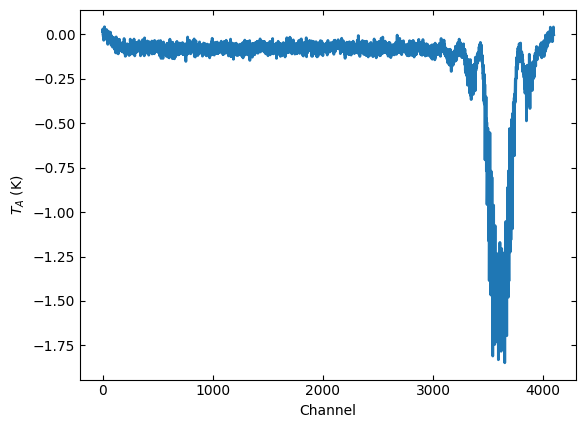

In [7]:
ps_scanblock = sdfits.getps(scan=19, plnum=0)
ps = ps_scanblock.timeaverage()
ps.plot(xaxis_unit="chan")

There is radio frequency interference (RFI) for channels above ~2300. We will plot a waterfall to see if the RFI is confined in time. For now, this kind of plot has to be done by hand.

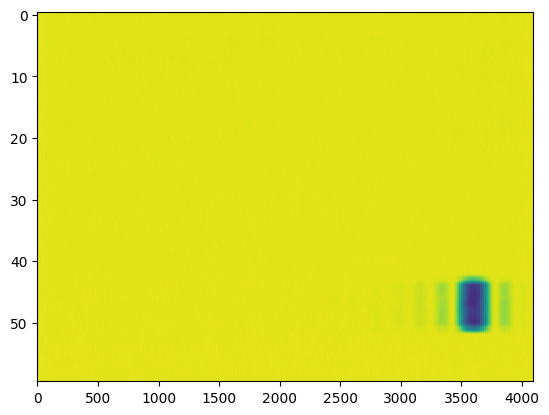

In [8]:
plt.figure()
plt.imshow(ps_scanblock[0]._calibrated, aspect="auto")

The RFI is confined to integrations 42 to 52, and it affects channels >2300. We will flag this range. Since the RFI shows as negative, it is also likely that this is present in the off scan, `scan=20`.

## Data Flagging

We use the `GBTFITSLoad.flag` method to generate flags.

In [9]:
sdfits.flags.clear()
sdfits.flag(scan=20, 
            channel=[[2300,4096]], 
            intnum=[i for i in range(42,53)])
sdfits.flags.show()

 ID    TAG    SCAN              INTNUM                   CHAN     # SELECTED
--- --------- ---- -------------------------------- ------------- ----------
  0 475d87b2a   20 [42,43,44,45,46...8,49,50,51,52] [[2300,4096]]         44


We repeat the calibration after generating the flags.

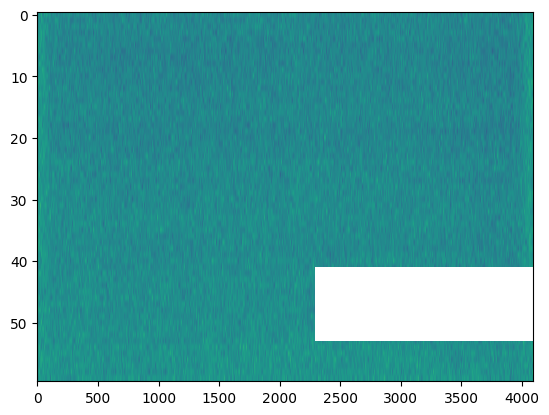

In [10]:
pssb = sdfits.getps(scan=19, plnum=0, apply_flags=True)

plt.figure()
plt.imshow(pssb[0]._calibrated, aspect="auto")

The channels and times affected by RFI have been flagged. We can time average to generate the final spectrum without the RFI.

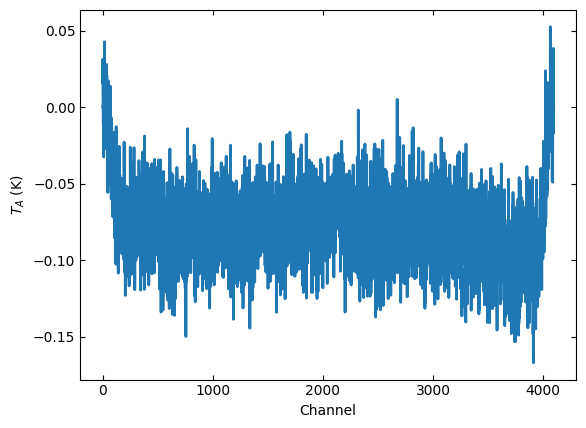

In [11]:
ps = pssb.timeaverage()
ps.plot(xaxis_unit="chan")

## Removing Flags

To remove flags from the `GBTFITSLoad` object use the `clear_flags` method.

In [12]:
sdfits.clear_flags()
sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS DURATION ... OBSTYPE SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- -------- ... ------- ---------- --------- ---- --- ----------


## Statistics-based Flagging
----------------------------------

We can assume that any significant increase in the standard deviation of the raw spectra is due to heavy RFI. Below, we will calculate mu + 3*sigma for each of the 8 individual switching states, and flag any integrations breaching that threshold.

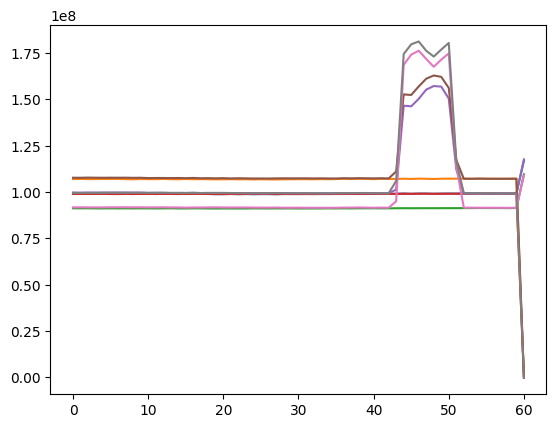

In [13]:
#Get raw spectra and standard deviations
specs = sdfits.rawspectra(0,0)
stdevs = np.std(specs,axis=1)


#Organize into scan and switching state.
#There are 2 signal states, 2 calibration diode states, and 2 polarizations.
stdevs = np.reshape(stdevs, (2,-1,4))

nrows = stdevs.shape[1]

#Inspect the data
for scan in range(2):
    for sw_state in range(4):
        plt.plot(stdevs[scan,:,sw_state])

We can see that the 4 states corresponding to the OFF scan have a significant jump corresponding to the GPS L3 RFI. It does not appear to start until the 40th integration, so we will use that as our cutoff to calculate the statistics of the good data, and the thresholds to flag by.

In [14]:
flag_mask = np.zeros(stdevs.shape)
cutoff = 40

mean = np.mean(stdevs[:,:cutoff,:],axis=1)
spread = 3 * np.std(stdevs[:,:cutoff,:],axis=1)

Now we create our flagging mask of zeros and ones, where a one corresponds to a flag to be applied.

In [15]:
flag_mask = np.zeros(stdevs.shape)

mean = np.expand_dims(mean,axis=1)
spread = np.expand_dims(spread,axis=1)

flag_mask[stdevs > mean+spread] = 1
flag_mask = flag_mask.flatten()

flag_rows = np.where(flag_mask==1)[0].tolist()
print(flag_rows)

[176, 178, 185, 186, 187, 190, 191, 194, 195, 198, 199, 201, 202, 203, 206, 207, 208, 209, 210, 211, 214, 215, 216, 217, 218, 219, 222, 223, 226, 227, 230, 231, 234, 235, 236, 237, 238, 239, 240, 242, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 484, 486]


We apply the flags using the "row" keyword, and see that the RFI is removed, along with a drop in the exposure time to 112 seconds instead of the original 150.

112.15101951854204


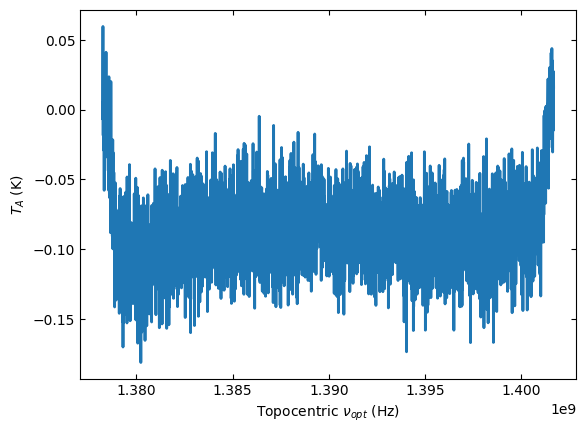

In [16]:
sdfits.flag(row=flag_rows)


ps = sdfits.getps(plnum=0).timeaverage()
print(ps.meta['EXPOSURE'])

ps.plot()